# Item based recommendation system

In [23]:
import pandas
import numpy as np
import time
import pylab as pl
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from recommender import song_similarity_model
from evaluator import precision_recall_calculator

### Preparing data
Data used is a subset of http://labrosa.ee.columbia.edu/millionsong

In [2]:
# triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
# songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'
# Download it locally for a faster usage
triplets_file = 'data/10000.txt'
metadata_file = 'data/song_data.csv'

In [3]:
song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

song_df_2 = pandas.read_csv(metadata_file)
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left")

### Observing data
We can see that the data represents how many times a user listened to a specfic song

In [4]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [5]:
len(song_df)

2000000

In [6]:
song_df = song_df.head(10000)
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

In [7]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
4378,The Scientist - Coldplay,27,0.27
4712,Use Somebody - Kings Of Leon,27,0.27
3476,Revelry - Kings Of Leon,26,0.26
1387,Fireflies - Charttraxx Karaoke,24,0.24
1862,Horn Concerto No. 4 in E flat K495: II. Romanc...,23,0.23


### Get unique users

In [8]:
users = song_df['user_id'].unique()

In [9]:
len(users)

365

### Splitting data into train and test sets

In [10]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)

In [11]:
train_data.head(5)

,user_id,song_id,listen_count,title,release,artist_name,year,song
7389,94d5bdc37683950e90c56c9b32721edb5d347600,SOXNZOW12AB017F756,2,Half Of My Heart,Battle Studies,John Mayer,0,Half Of My Heart - John Mayer
9275,1012ecfd277b96487ed8357d02fa8326b13696a5,SOXHYVQ12AB0187949,1,The Beautiful People,Antichrist Superstar (Ecopac Explicit),Marilyn Manson,0,The Beautiful People - Marilyn Manson
2995,15415fa2745b344bce958967c346f2a89f792f63,SOOSZAZ12A6D4FADF8,1,Sanctify Yourself,Glittering Prize 81/92,Simple Minds,1985,Sanctify Yourself - Simple Minds
5316,ffadf9297a99945c0513cd87939d91d8b602936b,SOWDJEJ12A8C1339FE,4,Heart Cooks Brain,Everything Is Nice: The Matador Records 10th A...,Modest Mouse,1997,Heart Cooks Brain - Modest Mouse
356,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAMPRJ12A8AE45F38,20,Rorol,Identification Parade,Octopus Project,2002,Rorol - Octopus Project


### Create a item similarity model

In [12]:
is_model = song_similarity_model(train_data)

### Recommend songs for the user

In [13]:
is_model.recommend(users[5])

,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.088692,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.067663,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.065385,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile - Justin Bieber,0.064525,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You - 3 Doors Down,0.062293,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound - J-Black & Masta Ace,0.055769,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Seed (2.0) - The Roots / Cody Chestnutt,0.052564,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm The One Who Understands (Edit Version) - War,0.052564,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Falling - Iration,0.052564,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Armed And Ready (2009 Digital Remaster) - The ...,0.052564,10


### Evaluation

In [16]:
start  =  time.time()

  #Define what percentage of users to use for precision recall calculation#Define  
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = precision_recall_calculator(test_data, train_data, is_model)

#Call method to calculate precision and recall values
(ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:eda12b54342243175dba3db83f66eade127d2b4e
Getting recommendations for user:956044d724390e40c8511b49e5bf6bc28071de3a
Getting recommendations for user:c24ec42f0e449ff39a95a01f0795f833b898f71b
Getting recommendations for user:4273611413c7199a53ee116edc8d7b0ba56482d5
Getting recommendations for user:4600442e761b6f636a08134b10b9b6c38cef6ba4
Getting recommendations for user:3187e658fd71be99d68d96f3a61a436c8a607365
Getting recommendations for user:1a640060dad45f7cb120578b24533f36907ad1b2
Getting recommendations for user:e11a55c8eecae195a596ca208ce69d2eb550689f
Getting recommendations for user:ea07020bb223c733ccc55aa925ebcc25c4d97377
Getting recommendations for user:4f18554aeb06f8d8612037549100d6d8d4afd021
Getting recommendations for user:4d4abafb7dd7a30206747398c9225f3e06942b3f
Getting recommendations for user:15cc706a7f24975ca831aaaf297bf0392746b3fe
Getting recommendations for user:07caa920795cd4f20

Plotting precision recall curves.


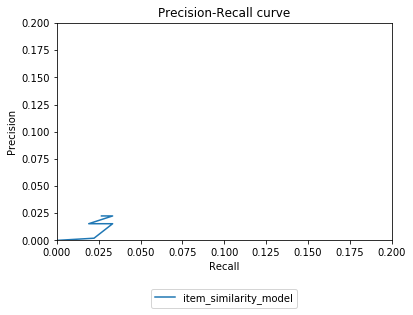

In [22]:
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()

print("Plotting precision recall curves.")

plot_precision_recall(ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


# LICENSE

Thierry Bertin-Mahieux, Daniel P.W. Ellis, Brian Whitman, and Paul Lamere. 
The Million Song Dataset. In Proceedings of the 12th International Society
for Music Information Retrieval Conference (ISMIR 2011), 2011.